In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER


In [2]:
import jax
import jax.numpy as jnp
from flax import nnx
from functools import partial
from jax_tqdm import scan_tqdm

from algorithms.utils import save_state_multiagent

import numpy as np

# jax.config.update("jax_debug_nans", True)

2025-02-28 17:57:40.549405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740761860.562871  355025 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740761860.566793  355025 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from ernestogym.envs_jax.multi_agent.env import RECEnv

In [4]:
def my_env_creator(params, battery_type):
    env = RECEnv(params, battery_type)
    return env

In [5]:
from ernestogym.envs_jax.multi_agent.utils import parameter_generator

In [26]:
pack_options = "ernestogym/ernesto_jax/data/battery_new/pack.yaml"
ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery_new/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
world = "ernestogym/envs_jax/multi_agent/world_deg.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"

# battery_type = 'fading'
# battery_type = 'degrading'
battery_type = 'degrading_dropflow'

params = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    use_reward_normalization=True

)

params

{'num_battery_agents': 5,
 'num_passive_houses': 0,
 'batteries': [{'sign_convention': 'passive',
   'params': {'nominal_voltage': 350.4,
    'nominal_capacity': 60.0,
    'nominal_dod': 0.8,
    'nominal_lifetime': 3000,
    'v_max': 398.4,
    'v_min': 288.0,
    'temp_ambient': 298.15,
    'nominal_cost': 3000.0},
   'bounds': {'voltage': {'low': 288.0, 'high': 398.4},
    'current': {'low': -180.0, 'high': 60.0},
    'power': {'low': -71712.0, 'high': 23904.0},
    'temperature': {'low': 273.15, 'high': 323.15},
    'temp_ambient': {'low': 273.15, 'high': 323.15},
    'soc': {'low': 0.2, 'high': 1.0},
    'soh': {'low': 0.6, 'high': 1.0}},
   'init': {'voltage': 310.8,
    'current': 0.0,
    'power': 0.0,
    'temperature': 293.15,
    'temp_ambient': 293.15,
    'soc': 0.2,
    'soh': 1.0}},
  {'sign_convention': 'passive',
   'params': {'nominal_voltage': 350.4,
    'nominal_capacity': 60.0,
    'nominal_dod': 0.8,
    'nominal_lifetime': 3000,
    'v_max': 398.4,
    'v_min': 2

In [7]:
# pack_options = "ernestogym/ernesto_jax/data/battery_new/pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_pack.yaml"
# # ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_fading_pack.yaml"
# r2c = "ernestogym/ernesto_jax/data/battery_new/models/thermal/r2c_thermal_pack.yaml"
# # bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
# world = "ernestogym/envs_jax/single_agent/ijcnn_deg_test.yaml"
# # world = "ernestogym/envs_jax/single_agent/world_fading.yaml"
#
# params_testing = parameter_generator(
#     input_var='current',
#     battery_options=pack_options,
#     electrical_model=ecm,
#     thermal_model=r2c,
#     aging_model=bolun,
#     world_options=world,
#     use_reward_normalization=True
#
# )
#
# params_testing['step']

In [8]:
from algorithms.multi_agent_ppo import make_train, train        #, train_for, train_for_flax
from flax.core.frozen_dict import freeze, unfreeze

In [9]:
# num_envs = 4

config = {
    "LR": 1e-3,
    # "NUM_ENVS": num_envs,
    "NUM_STEPS": 8192, #2048 #10000,
    # "TOTAL_TIMESTEPS": 100000 * num_envs,
    "TOTAL_TIMESTEPS": 876000,
    "UPDATE_EPOCHS": 10,
    "NUM_MINIBATCHES": 32,
    "NORMALIZE_ENV": False,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "NET_ARCH": (64, 32, 16), #(16, 16, 16),
    "ACTIVATION": 'swish',
    "LOGISTIC_FUNCTION_TO_ACTOR": False,
    "ENV_NAME": None,
    "ANNEAL_LR": True,
    'DEBUG': False,
    "NORMALIZE_ADVANTAGES": True,
    "ENV_TYPE": 'normal',
    'NETWORK': 'actor_critic'
}

env_type = config['ENV_TYPE']

rng = jax.random.PRNGKey(42)

env = my_env_creator(params, battery_type)
env, train_state = make_train(config, env)

# env_testing, env_testing_params = my_env_creator(params_testing, battery_type)

val_rng = jax.random.PRNGKey(51)
val_num_iters = 8670*8

# out = train_jit(rng)

config = freeze(config)

In [10]:
env.battery_agents

['battery_agent_0',
 'battery_agent_1',
 'battery_agent_2',
 'battery_agent_3',
 'battery_agent_4']

In [11]:
networks_batteries, optimizer_batteries, network_rec, optimizer_rec = nnx.merge(train_state.graph_def, train_state.state)

In [12]:
networks_batteries

WrappedStackedActorCritic(
  vmappd_module=StackedActorCritic(
    act_layers=[Linear(
      bias=Param(
        value=Array(shape=(5, 64), dtype=float32)
      ),
      bias_init=<function constant.<locals>.init at 0x7430604f2d40>,
      dot_general=<function dot_general at 0x7431125e7c40>,
      dtype=None,
      in_features=10,
      kernel=Param(
        value=Array(shape=(5, 10, 64), dtype=float32)
      ),
      kernel_init=<function orthogonal.<locals>.init at 0x7430604f23e0>,
      out_features=64,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      use_bias=True
    ), <PjitFunction of <function silu at 0x743111d2e160>>, Linear(
      bias=Param(
        value=Array(shape=(5, 32), dtype=float32)
      ),
      bias_init=<function constant.<locals>.init at 0x7430604c13a0>,
      dot_general=<function dot_general at 0x7431125e7c40>,
      dtype=None,
      in_features=64,
      kernel=Param(
        value=Array(shape=(5, 64, 32), dtype=float32)
      ),
  

In [13]:
network_rec

RECActorCritic(
  act_layers=[Linear(
    bias=Param(
      value=Array(shape=(64,), dtype=float32)
    ),
    bias_init=<function constant.<locals>.init at 0x7430605d3e20>,
    dot_general=<function dot_general at 0x7431125e7c40>,
    dtype=None,
    in_features=12,
    kernel=Param(
      value=Array(shape=(12, 64), dtype=float32)
    ),
    kernel_init=<function orthogonal.<locals>.init at 0x7430605d3ec0>,
    out_features=64,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    use_bias=True
  ), <PjitFunction of <function silu at 0x743111d2e160>>, Linear(
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    bias_init=<function constant.<locals>.init at 0x743060305f80>,
    dot_general=<function dot_general at 0x7431125e7c40>,
    dtype=None,
    in_features=64,
    kernel=Param(
      value=Array(shape=(64, 32), dtype=float32)
    ),
    kernel_init=<function orthogonal.<locals>.init at 0x743060306160>,
    out_features=32,
    param_dtype=<clas

In [14]:
import time
import matplotlib.pyplot as plt
rng = jax.random.PRNGKey(42)
t0 = time.time()

# with jax.checking_leaks():
out = jax.block_until_ready(train(env, config, train_state, rng, validate=False)) #, freq_val=10, val_env=env_testing, val_params=env_testing_params, val_rng=val_rng, val_num_iters=val_num_iters))

train_state = out['runner_state'][0]

print(f"time: {time.time() - t0:.2f} s")
# plt.plot(out["metrics"]["returned_episode_returns"].mean(-1).reshape(-1))
# plt.xlabel("Update Step")
# plt.ylabel("Return")
# plt.show()

Running for 106 iterations:   0%|          | 0/106 [00:00<?, ?it/s]

time: 532.18 s


In [15]:
jax.tree.map(lambda x: x.shape, out['metrics'])

{'actions': {'REC_agent': (106, 8192, 5),
  'battery_agent_0': (106, 8192, 1),
  'battery_agent_1': (106, 8192, 1),
  'battery_agent_2': (106, 8192, 1),
  'battery_agent_3': (106, 8192, 1),
  'battery_agent_4': (106, 8192, 1)},
 'norm_reward': {'r_clipping': (106, 8192, 5),
  'r_deg': (106, 8192, 5),
  'r_op': (106, 8192, 5),
  'r_trad': (106, 8192, 5)},
 'pure_reward': {'r_clipping': (106, 8192, 5),
  'r_deg': (106, 8192, 5),
  'r_op': (106, 8192, 5),
  'r_trad': (106, 8192, 5)},
 'r_glob': (106, 8192, 5),
 'r_tot': (106, 8192, 5),
 'rec_reward': (106, 8192),
 'self_consumption': (106, 8192),
 'soc': (106, 8192, 5),
 'soh': (106, 8192, 5),
 'tot_incentives': (106, 8192),
 'weig_reward': {'r_clipping': (106, 8192, 5),
  'r_deg': (106, 8192, 5),
  'r_op': (106, 8192, 5),
  'r_trad': (106, 8192, 5)}}

In [16]:
jax.tree.map(lambda x: jnp.isnan(x).any(), out['metrics'])

{'actions': {'REC_agent': Array(False, dtype=bool),
  'battery_agent_0': Array(False, dtype=bool),
  'battery_agent_1': Array(False, dtype=bool),
  'battery_agent_2': Array(False, dtype=bool),
  'battery_agent_3': Array(False, dtype=bool),
  'battery_agent_4': Array(False, dtype=bool)},
 'norm_reward': {'r_clipping': Array(False, dtype=bool),
  'r_deg': Array(False, dtype=bool),
  'r_op': Array(False, dtype=bool),
  'r_trad': Array(False, dtype=bool)},
 'pure_reward': {'r_clipping': Array(False, dtype=bool),
  'r_deg': Array(False, dtype=bool),
  'r_op': Array(False, dtype=bool),
  'r_trad': Array(False, dtype=bool)},
 'r_glob': Array(False, dtype=bool),
 'r_tot': Array(False, dtype=bool),
 'rec_reward': Array(False, dtype=bool),
 'self_consumption': Array(False, dtype=bool),
 'soc': Array(False, dtype=bool),
 'soh': Array(False, dtype=bool),
 'tot_incentives': Array(False, dtype=bool),
 'weig_reward': {'r_clipping': Array(False, dtype=bool),
  'r_deg': Array(False, dtype=bool),
  'r_o

In [17]:
jax.tree.map(lambda x: jnp.isnan(x).any(axis=jnp.arange(1, x.ndim)), out['metrics'])

{'actions': {'REC_agent': Array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False], dtype=bool),
  'battery_agent_0': Array([False, False, False, False, False, False, False, False, False,
         False, False

In [18]:
out['metrics']['actions']['REC_agent']

Array([[[2.78616726e-01, 9.35690999e-02, 1.02294244e-01, 4.43619043e-01,
         8.19008797e-02],
        [9.48959649e-01, 1.77695919e-02, 2.94121057e-02, 2.96839629e-03,
         8.90227675e-04],
        [5.08367606e-02, 6.83493689e-02, 2.34346539e-01, 2.21151516e-01,
         4.25315827e-01],
        ...,
        [1.69625506e-01, 9.28754583e-02, 4.21953499e-01, 3.24957864e-03,
         3.12296033e-01],
        [3.14647138e-01, 3.52817446e-01, 6.86718673e-02, 9.32347253e-02,
         1.70628861e-01],
        [1.85863048e-01, 2.69867748e-01, 7.06461072e-02, 3.74708325e-01,
         9.89148095e-02]],

       [[2.87517048e-02, 2.58295327e-01, 1.89820468e-01, 2.08835497e-01,
         3.14297020e-01],
        [1.45722670e-03, 1.16357245e-01, 1.04802459e-01, 2.30461344e-01,
         5.46921730e-01],
        [1.89603437e-02, 1.52722210e-01, 2.94250846e-01, 1.49337739e-01,
         3.84728789e-01],
        ...,
        [3.16285092e-04, 3.72926652e-01, 5.22939861e-01, 5.80158606e-02,
        

In [19]:
out['metrics']['pure_reward']['r_clipping'][3]

Array([[   0.      , -540.07135 ,    0.      ,  -22.982388,    0.      ],
       [   0.      , -292.4364  ,    0.      , -337.31705 ,    0.      ],
       [   0.      , -164.29979 ,    0.      ,    0.      ,    0.      ],
       ...,
       [   0.      ,    0.      ,    0.      ,    0.      ,    0.      ],
       [   0.      ,    0.      ,    0.      ,    0.      ,    0.      ],
       [   0.      ,    0.      ,    0.      ,    0.      ,    0.      ]],      dtype=float32)

In [20]:
network_batteries, optimizer_batteries, network_rec, optimizer_rec = nnx.merge(train_state.graph_def, train_state.state)
network_batteries

WrappedStackedActorCritic(
  vmappd_module=StackedActorCritic(
    act_layers=[Linear(
      bias=Param(
        value=Array(shape=(5, 64), dtype=float32)
      ),
      bias_init=<function constant.<locals>.init at 0x7430604f2d40>,
      dot_general=<function dot_general at 0x7431125e7c40>,
      dtype=None,
      in_features=10,
      kernel=Param(
        value=Array(shape=(5, 10, 64), dtype=float32)
      ),
      kernel_init=<function orthogonal.<locals>.init at 0x7430604f23e0>,
      out_features=64,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      use_bias=True
    ), <PjitFunction of <function silu at 0x743111d2e160>>, Linear(
      bias=Param(
        value=Array(shape=(5, 32), dtype=float32)
      ),
      bias_init=<function constant.<locals>.init at 0x7430604c13a0>,
      dot_general=<function dot_general at 0x7431125e7c40>,
      dtype=None,
      in_features=64,
      kernel=Param(
        value=Array(shape=(5, 64, 32), dtype=float32)
      ),
  

## State saving

In [29]:
save_state_multiagent(network_batteries, network_rec, config, params, env_type=env_type, additional_info='')

In [30]:
out

{'metrics': {'actions': {'REC_agent': Array([[[2.78616726e-01, 9.35690999e-02, 1.02294244e-01, 4.43619043e-01,
            8.19008797e-02],
           [9.48959649e-01, 1.77695919e-02, 2.94121057e-02, 2.96839629e-03,
            8.90227675e-04],
           [5.08367606e-02, 6.83493689e-02, 2.34346539e-01, 2.21151516e-01,
            4.25315827e-01],
           ...,
           [1.69625506e-01, 9.28754583e-02, 4.21953499e-01, 3.24957864e-03,
            3.12296033e-01],
           [3.14647138e-01, 3.52817446e-01, 6.86718673e-02, 9.32347253e-02,
            1.70628861e-01],
           [1.85863048e-01, 2.69867748e-01, 7.06461072e-02, 3.74708325e-01,
            9.89148095e-02]],
   
          [[2.87517048e-02, 2.58295327e-01, 1.89820468e-01, 2.08835497e-01,
            3.14297020e-01],
           [1.45722670e-03, 1.16357245e-01, 1.04802459e-01, 2.30461344e-01,
            5.46921730e-01],
           [1.89603437e-02, 1.52722210e-01, 2.94250846e-01, 1.49337739e-01,
            3.84728789e-01],

In [31]:
r_trad = out['metrics']['weig_reward']['r_trad'].mean(-1).reshape(-1)
r_trad_cum = np.cumsum(r_trad)
r_trad.shape

(868352,)

In [32]:
acts = out['metrics']['action'].flatten()
acts.min(), acts.max(), acts.mean()

KeyError: 'action'

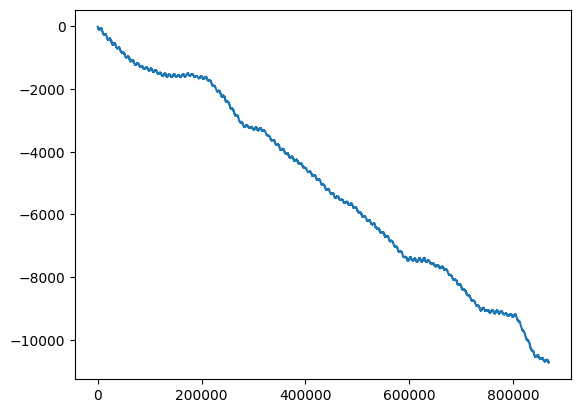

In [18]:
plt.plot(r_trad_cum)

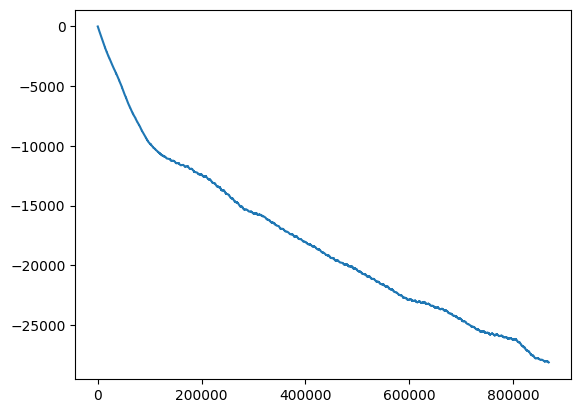

In [19]:
r_tot_cum = np.cumsum(out['metrics']['r_tot'].mean(-1).reshape(-1))
plt.plot(r_tot_cum)

# Testing

In [20]:
pack_options = "ernestogym/ernesto_jax/data/battery_new/pack.yaml"
ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery_new/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
world = "ernestogym/envs_jax/single_agent/ijcnn_deg_test.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"

# battery_type = 'fading'
# battery_type = 'degrading'
battery_type = 'degrading_dropflow'

params = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    use_reward_normalization=True

)

params['step']

3600

In [21]:
@partial(jax.jit, static_argnums=(0, 2, 3))
def test(env: MicroGridEnv, env_params, network, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, env_params)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        obsv, env_state, rng = runner_state

        pi, _ = network(obsv)

        #deterministic action
        action = pi.mode()

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward, done, info = env.step(_rng, env_state, action, env_params)

        runner_state = (obsv, env_state, rng)
        return runner_state, (info, action)

    runner_state = (obsv, env_state, rng)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [22]:
env, env_params = my_env_creator(params, battery_type, env_type=env_type)
env_params = env.eval(env_params)

In [23]:
num_iter = 8760 * 8
info, actions = test(env, env_params, network, num_iter, jax.random.PRNGKey(51))


Running for 70,080 iterations:   0%|          | 0/70080 [00:00<?, ?it/s]

In [24]:
jax.tree.map(lambda val: val.shape, info)

{'buy_price': (70080,),
 'demand': (70080,),
 'generation': (70080,),
 'i_to_apply': (70080,),
 'norm_reward': {'r_clipping': (70080,),
  'r_deg': (70080,),
  'r_op': (70080,),
  'r_trad': (70080,)},
 'p': (70080,),
 'pure_reward': {'r_clipping': (70080,),
  'r_deg': (70080,),
  'r_op': (70080,),
  'r_trad': (70080,)},
 'r_tot': (70080,),
 'sell_price': (70080,),
 'soc': (70080,),
 'soh': (70080,),
 'weig_reward': {'r_clipping': (70080,),
  'r_deg': (70080,),
  'r_op': (70080,),
  'r_trad': (70080,)}}

In [25]:
actions.max(), actions.min(), actions.mean()

(Array(0.9900348, dtype=float32),
 Array(-0.28921312, dtype=float32),
 Array(-0.02295205, dtype=float32))

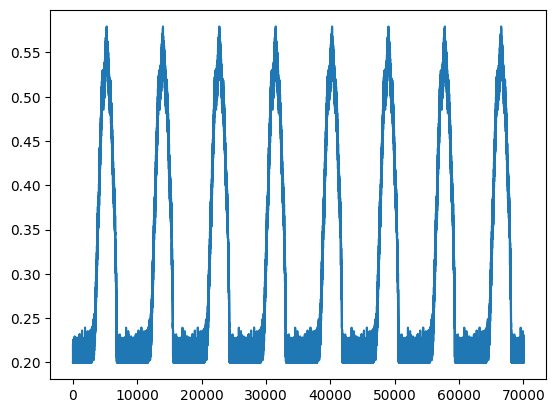

In [26]:
plt.plot(info['soc'])

In [27]:
reward_type = 'weig_reward'

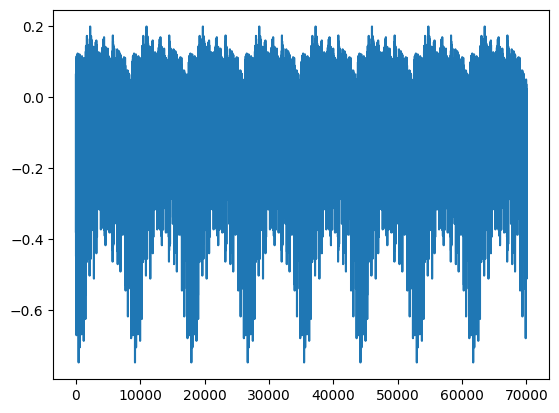

In [28]:
plt.plot(info[reward_type]['r_trad'])

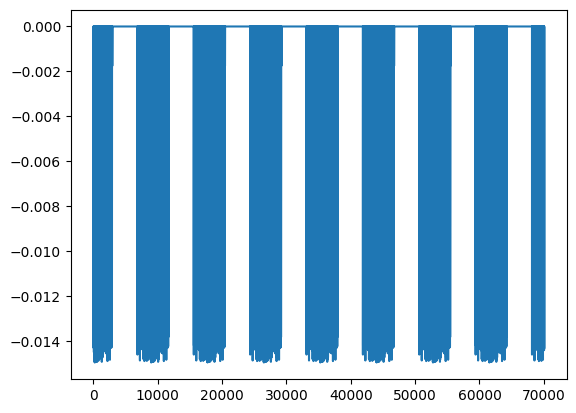

In [29]:
plt.plot(info[reward_type]['r_clipping'])

In [30]:
info['pure_reward']['r_clipping'].mean(), info['weig_reward']['r_clipping'].mean()

(Array(-7.9687448, dtype=float32), Array(-0.0023472, dtype=float32))

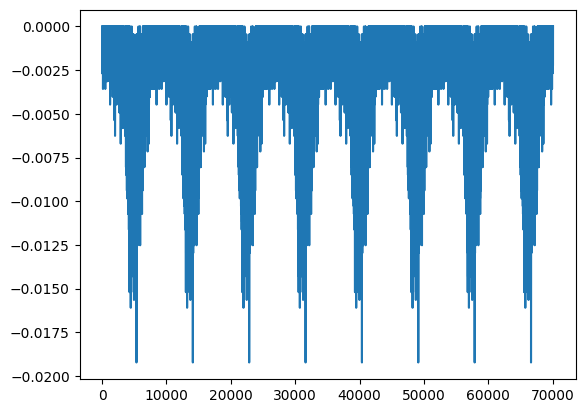

In [31]:
plt.plot(info[reward_type]['r_deg'])

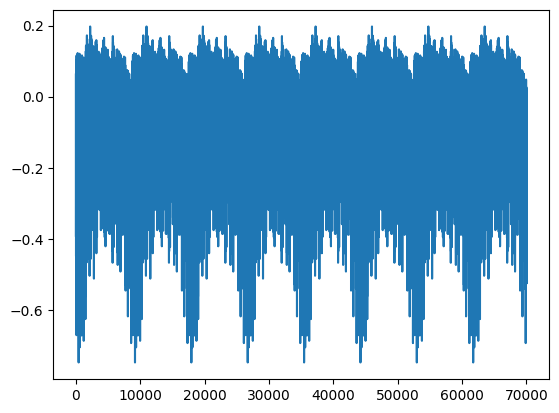

In [32]:
plt.plot(info['r_tot'])

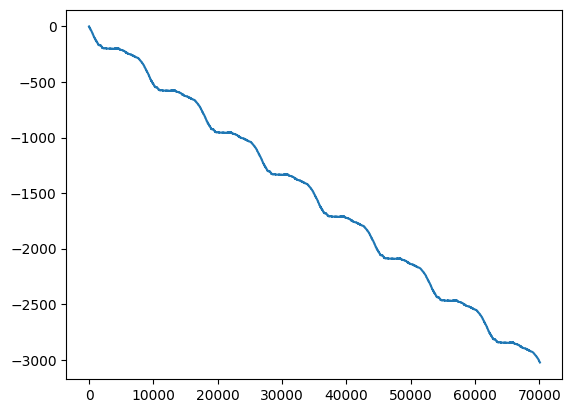

In [33]:
plt.plot(np.cumsum(info[reward_type]['r_trad']))

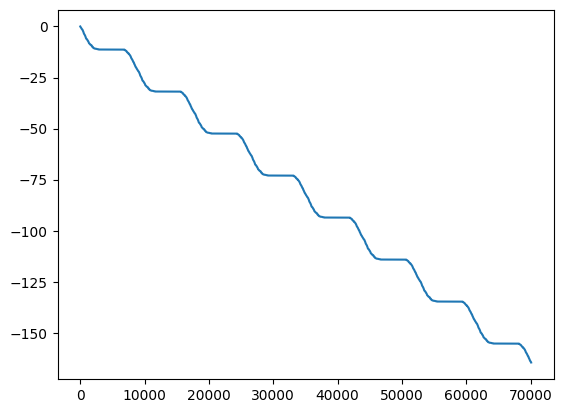

In [34]:
plt.plot(np.cumsum(info[reward_type]['r_clipping']))

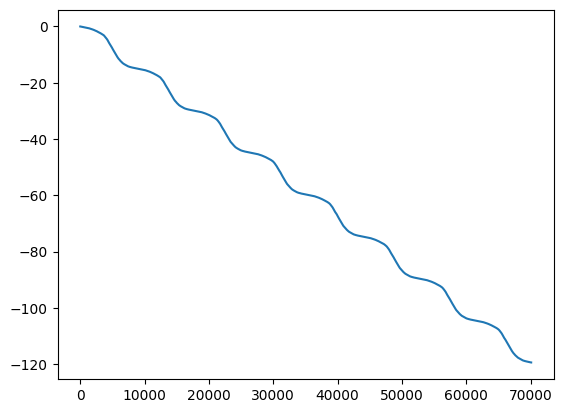

In [35]:
plt.plot(np.cumsum(info[reward_type]['r_deg']))

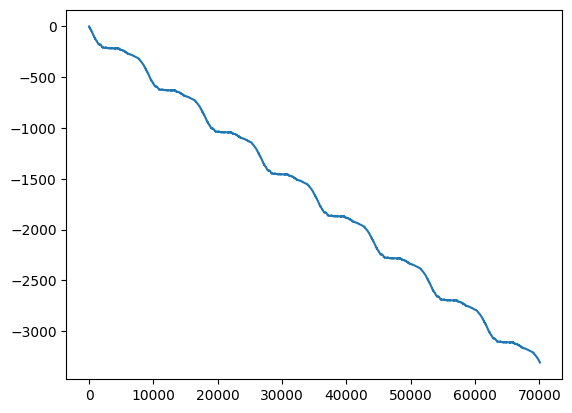

In [36]:
plt.plot(np.cumsum(info['r_tot']))

In [37]:
print(info['soc'])

[0.2 0.2 0.2 ... 0.2 0.2 0.2]


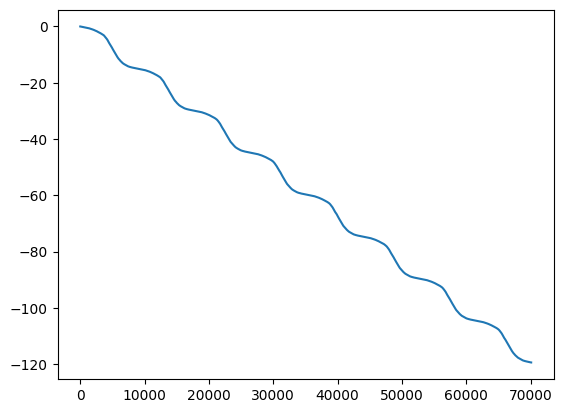

In [38]:
plt.plot(np.cumsum(info[reward_type]['r_deg']))

In [39]:
print(info['soc'])

[0.2 0.2 0.2 ... 0.2 0.2 0.2]
